# Kullback-Leibler-Distance implementation and comparison
-  Visualization of mode dropping on a synthetical data example
-  "Simulation" of a GAN dataset (real and synthetical (generator) dataset)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.legend_handler import HandlerLine2D
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

## Set up a synthetical real dataset to accomplish a sensitivity test

In [2]:
# Defintion: Real data distribution with 3 peaks with different means and standard deviations
n_samples_real = 10000
peak1 = np.random.normal(5, 0.4, n_samples_real)

peak2 = 1*np.random.normal(2,0.2, n_samples_real)

peak3 = 1*np.random.normal(7,0.4, n_samples_real)
peak3.shape

(10000,)

In [3]:
# Concatenate samples into real dataset --> CDF
real_data = np.concatenate([peak1, peak2, peak3])
real_data.shape

(30000,)

## Set up two synthetical generator datasets to accomplish a sensitivity test

In [4]:
# First generator distribution - 1 peak
distribution1_peak1 = np.random.normal(2, 0.4, 30000)
distribution1 = distribution1_peak1

# Second generator distribution - 3 peaks
distribution2_peak1 = np.random.normal(5, 0.6, 10000)
distribution2_peak2 = np.random.normal(2, 0.8, 10000)
distribution2_peak3 = np.random.normal(7, 0.8, 10000)
distribution2 = np.concatenate([distribution2_peak1, distribution2_peak2, distribution2_peak3])
distribution2.shape

(30000,)

# Bin data to get histogram - Input format for KLD calculation
-  Bins have to be equal for real and model data to calculate KLD afterwards!

In [5]:
# Minimum probability, KLD calculation fails otherwise due to division by 0
min_prob = 10**-9

# Hyperparameter: Number of bins
num_bins = 300

# Set up histogram dynamically, data dependent
min_value = np.min([real_data, distribution1, distribution2])
max_value = np.max([real_data, distribution1, distribution2])
bin_width = (max_value - min_value)/num_bins

In [6]:
# Histogram edges equals number of bins+1
bin_edges = []
for idx in range(num_bins): 
    bin_edges = np.append(bin_edges, min_value + idx*bin_width)
bin_edges = np.append(bin_edges, max_value)

In [7]:
# Create histogram with real dataset and predefined bin edges (equal for real and simulation data)
counts_real, bin_edges_real = np.histogram(real_data, bins=bin_edges, density=True)
# Calculate integration (1 in total equal PDF) with bin area and height (counts_real)
counts_real = counts_real*np.diff(bin_edges)

In [8]:
# Set minimal probability if no samples in bin
for count_idx, count in enumerate(counts_real): 
    if count==0: 
        counts_real[count_idx] = min_prob

In [9]:
# Create histogram with synthetical dataset 1 and predefined bin edges (equal for real and simulation data)
counts_dist1, bin_edges_dist1 = np.histogram(distribution1, bins=bin_edges, density=True)
counts_dist1 = counts_dist1*np.diff(bin_edges)
for count_idx, count in enumerate(counts_dist1):
     if count == 0: 
            counts_dist1[count_idx] = min_prob
    
# Create histogram with synthetical dataset 2 and predefined bin edges (equal for real and simulation data)
counts_dist2, bin_edges_dist2 = np.histogram(distribution2, bins=bin_edges, density=True)
counts_dist2 = counts_dist2*np.diff(bin_edges)
for count_idx, count in enumerate(counts_dist2):
     if count == 0: 
            counts_dist2[count_idx] = min_prob

In [12]:
# Check PDFs by area (around 1!)
print('Check: Integration of PDF should lead to ~1!')
print('Real data PDF area: {}'.format(np.sum(counts_real)))
print('Simulation data 1 PDF area: {}'.format(np.sum(counts_dist1)))
print('Simulation data 2 PDF area: {}'.format(np.sum(counts_dist2)))

Check: Integration of PDF should lead to ~1!
Real data PDF area: 1.0000001379999999
Simulation data 1 PDF area: 1.000000221
Simulation data 2 PDF area: 1.000000031


## After PDF generation, CDF calculation by integral

In [13]:
# Generate CDF for synthetical real and simulation datasets
cdf_real = np.cumsum(counts_real)
cdf_dist1 = np.cumsum(counts_dist1)
cdf_dist2 = np.cumsum(counts_dist2)

print('CDF output shape and type: {}, {}'.format(cdf_real.shape, type(cdf_real)))

CDF output shape and type: (300,), <class 'numpy.ndarray'>


## Plot the CDFs

In [14]:
# Set up figure with LaTex setting
fig = plt.gcf()
fig.set_size_inches(13,7)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Define datasets with colors: Real = green; Simulation = red, black
plt.plot(bin_edges[0:-1], cdf_real, linestyle='--', linewidth = 5, color='green', label=r'Real distribution')
plt.plot(bin_edges[0:-1], cdf_dist1, linestyle='--', linewidth = 5, color='red', label=r'Model distribution 1')
plt.plot(bin_edges[0:-1], cdf_dist2, linestyle='--', linewidth = 5, color='black', label=r'Model distribution 2')

# Plot properties
plt.ylim((0,1))
plt.ylabel(r"CDF", fontsize=20)
plt.xlabel(r'x', fontsize=20)
plt.grid(True)
plt.title(r"Distribution of real and model data - CDF", fontsize=20, color='black')
plt.legend(fontsize=20)

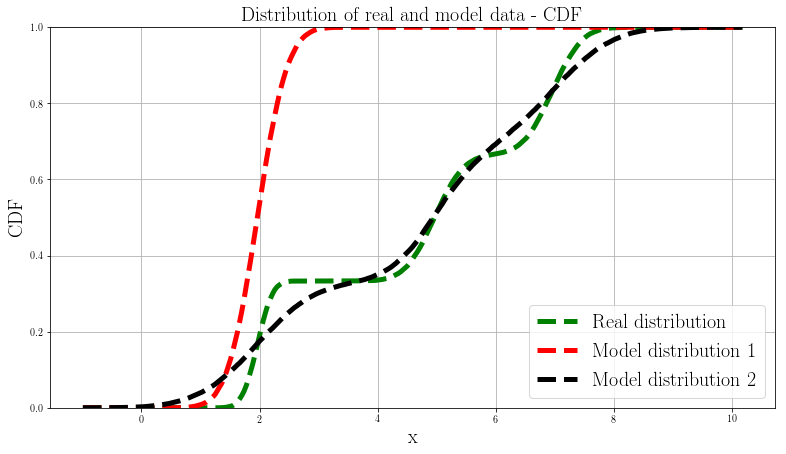

In [19]:
# Show figure with three datasets
plt.show()

In [15]:
# Set save flag as False (No saving process by accident)
save_flag = False

# Save figure in current working folder
if save_flag: 
    fig.savefig('KLD_comparison_CDF.eps', format='eps', dpi=1000)

## Sample from generated CDFs 

In [16]:
def sample_from_cdf(num_samples, cdf, bin_edges): 
    '''
        Explanation:         From a given Cummulative Density Function CDF 
        ------------         samples need to be drawn for Kullback-Leibler-Distance KLD calculation. 
                             The mathematical basis for this calculation is the simulation theorem. 
                             Sampling from a uniform distribution as input for a CDF to extract samples
                             from the CDF underlying distribution.

        Parameters: 
        -----------
            cdf              Cumulative Density Function (1D numpy array)
            num_samples      Number of samples to get from given CDF (integer)
    '''
    print('Sample from CDF!')
    
    # Sample from uniform distribution
    random_numbers = np.random.uniform(0, 1, num_samples)
    
    samples = []
    
    # Iterate all random numbers from uniform distribution, since this is a discrete implementation for 
    # sampling due to obvious reasons, the closest random sample value is used in the CDF distribution
    # through its index via the bin_edges containing 
    for _, random_number in enumerate(random_numbers): 
        idx = (np.abs(cdf - random_number)).argmin()
        #samples = np.append(samples, cdf[idx])
        samples = np.append(samples, bin_edges[idx])
        
    #print(random_number)
    
    return samples

In [17]:
# Applicate Sampling process from CDFs (real, simulation data 1,2)
n_samples=1000
pdf_real = sample_from_cdf(n_samples, cdf_real, bin_edges)
pdf_distr1 = sample_from_cdf(n_samples, cdf_dist1, bin_edges)
pdf_distr2 = sample_from_cdf(n_samples, cdf_dist2, bin_edges)

Sample from CDF!
Sample from CDF!
Sample from CDF!


In [18]:
# Generate PDF through histogram with sampled data from CDF

# Real samples histogram
pdf_real, bins_real = np.histogram(pdf_real, bins = bin_edges, density=True)
for count_idx, count in enumerate(pdf_real):
     if count == 0: 
            pdf_real[count_idx] = min_prob
pdf_real = pdf_real*np.diff(bin_edges)
            
# Model 1 samples histogram
pdf_dist1, bins_dist1 = np.histogram(pdf_distr1, bins = bin_edges, density=True)
for count_idx, count in enumerate(pdf_dist1):
     if count == 0: 
            pdf_dist1[count_idx] = min_prob
pdf_dist1 = pdf_dist1*np.diff(bin_edges)

# Model 2 samples histogram
pdf_dist2, bins_dist2 = np.histogram(pdf_distr2, bins = bin_edges, density=True)
for count_idx, count in enumerate(pdf_dist2):
     if count == 0: 
            pdf_dist2[count_idx] = min_prob
pdf_dist2 = pdf_dist2*np.diff(bin_edges)

In [19]:
# Check histograms by area (around 1!)
print('Check: Integration of PDF should lead to ~1!')
print('Real data PDF area: {}'.format(np.sum(pdf_real)))
print('Simulation data 1 PDF area: {}'.format(np.sum(pdf_dist1)))
print('Simulation data 2 PDF area: {}'.format(np.sum(pdf_dist2)))

Check: Integration of PDF should lead to ~1!
Real data PDF area: 1.000000006497848
Simulation data 1 PDF area: 1.0000000092052845
Simulation data 2 PDF area: 1.000000003364957


In [20]:
# Kullback-Leibler-Distance: Between generator and real data samples

def KLD(pdf_real, pdf_sim): 
    print('Calculate KLD(pg||pr) = KLD(p_sim||p_real: From generator distribution to real data distribution')
    if not len(pdf_real) == len(pdf_sim): 
        print('Error: pdf arrays have to be of equal size!')
    
    kld_value = 0
    for idx, pdf_value in enumerate(pdf_sim): 
        kld_value += pdf_sim[idx] * np.log(pdf_sim[idx]/pdf_real[idx]) * bin_width
        
    return kld_value

In [21]:
# Calculate distances between real and model distributions
kld_dist1 = KLD(pdf_real, pdf_dist1)
kld_dist2 = KLD(pdf_real, pdf_dist2)

Calculate KLD(pg||pr) = KLD(p_sim||p_real: From generator distribution to real data distribution
Calculate KLD(pg||pr) = KLD(p_sim||p_real: From generator distribution to real data distribution


In [22]:
# Check: Distance to model 1 distribution is expected to be greater than model 2 distribution
print('KLD value between model distribution 1 and real data distribution: {}'.format(kld_dist1))
print('KLD value between model distribution 2 and real data distribution: {}'.format(kld_dist2))

KLD value between model distribution 1 and real data distribution: 0.15098256303487198
KLD value between model distribution 2 and real data distribution: 0.16245219314019552


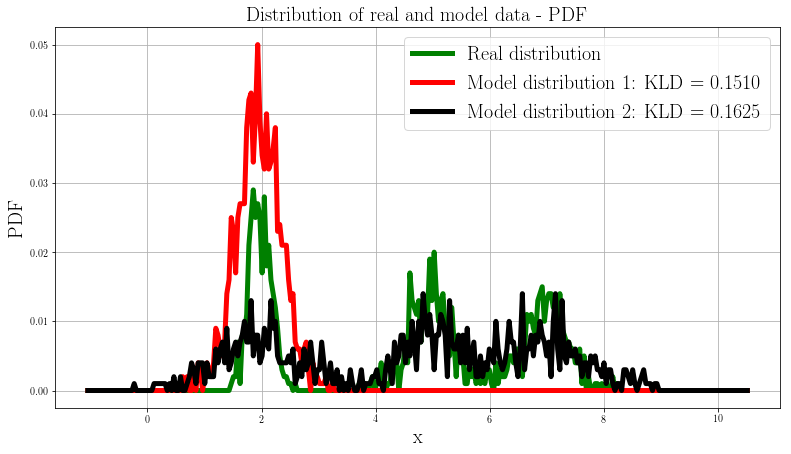

In [24]:
# Set figure properties
fig = plt.gcf() 
fig.set_size_inches(13,7)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Plot the pdf
plt.plot(bin_edges[0:-1], pdf_real,linestyle='-', color='green', label=r'Real distribution', linewidth = 5)
plt.plot(bin_edges[0:-1], pdf_dist1,linestyle='-', color='red', label=r'Model distribution 1: KLD = {0:.4f}'.format(kld_dist1), linewidth = 5)
plt.plot(bin_edges[0:-1], pdf_dist2,linestyle='-', color='black', label=r'Model distribution 2: KLD = {0:.4f}'.format(kld_dist2), linewidth = 5)

# Set figure properties
plt.ylabel("PDF", fontsize=20)
plt.xlabel('x', fontsize=20)
plt.grid(True)
#plt.ylim((0,1))

# Set title
plt.title(r"Distribution of real and model data - PDF", fontsize=20, color='black')

# Set legend
plt.legend(fontsize=20)

# Show plot
plt.show()

In [28]:
# Set save flag as False (No saving process by accident)
save_flag = False

# Save figure in current working folder
if save_flag: 
    fig.savefig('KLD_comparison_PDF.eps', format='eps', dpi=1000)